### Let's use a benchmark BEM problem to test if the current functions are working correctly.

In [1]:
%matplotlib widget

In [2]:
from acousticBEM.AcousticProperties import *
from acousticBEM.BoundaryData import *
from acousticBEM.ExampleBoundaries import *
from acousticBEM.Geometry import *
from acousticBEM.HelmholtzIntegrals2D import *
from acousticBEM.HelmholtzSolver import *
from acousticBEM.HelmholtzSolver2D import *

In [3]:
import numpy as np
from numpy import log, sin, cos, arctan2, pi, mean, dot
from numpy.linalg import norm, solve
from scipy.special import roots_legendre, hankel1
from scipy.integrate import quad
import matplotlib.pyplot as plt
from misc.add_funs_mod import *
import meshio
import gmsh
import sys

---

### Original field (Analytic)

In [4]:
# Screen width and height
upper_grid_size = 5
lower_grid_size = 0
ngrid_pts = 70

grid_vec = np.linspace(lower_grid_size,upper_grid_size,num=ngrid_pts)

X,Y = np.meshgrid(grid_vec,grid_vec)

k = 3

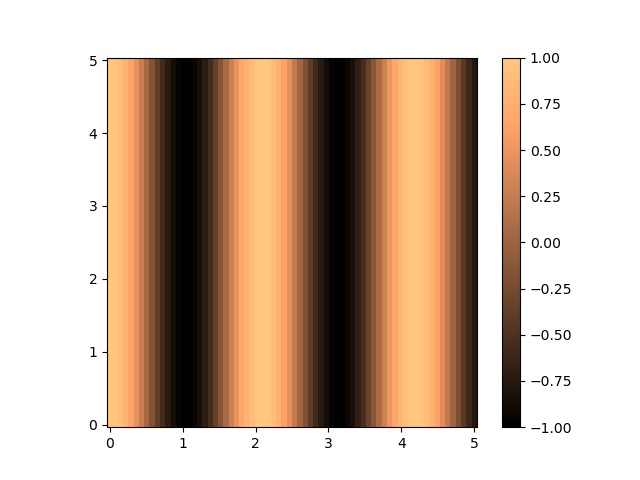

In [80]:
# Define the first field
#ui_fun = lambda k,x,y: np.sin(k*x)*np.sin(k*y)
ui_fun = lambda k, x, y: np.cos(k * x)

# Plot the surface

fig, ax = plt.subplots()
plot = ax.pcolormesh(X, Y, ui_fun(k,X,Y), edgecolor="none",cmap="copper",vmax=1, vmin=-1)
ax.axis('equal')
ax.set_aspect('equal', 'box')

cbar = fig.colorbar(plot,ax=ax)
plt.show()

---

### BEM alternative

In [6]:
# GMSH mesh geometry generation
create_square_geo(lower_grid_size, upper_grid_size, 0.1, ngrid_pts)

In [7]:
gmsh.initialize()
gmsh.open("simple_square_bound.geo")
gmsh.model.mesh.generate(1)  # 1D mesh

gmsh.write("simple_square_bound.msh")
gmsh.finalize()

In [8]:
fname = "simple_square_bound.msh"
mesh = meshio.read(fname)

In [9]:
mesh, coords, elems, x_m, y_m, id_dir, id_neu = read_geo_gmsh(fname, [0,1,2,3], None)
elems = np.flip(elems[:, ::-1], axis=0) # For interior problems
x_m, y_m = 0.5*(coords[elems[:, 0]] + coords[elems[:, 1]]).T

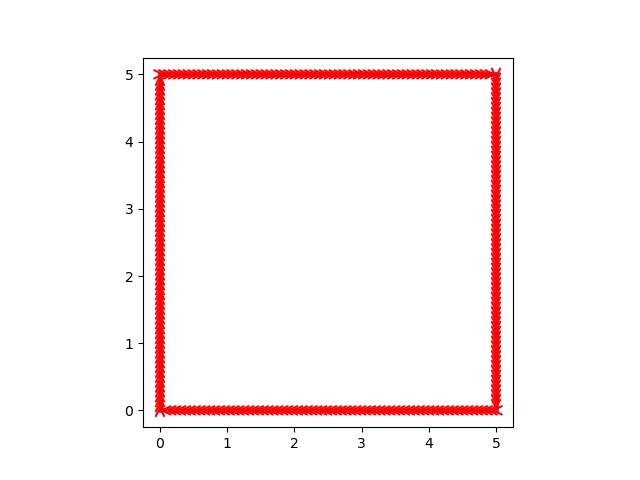

In [73]:
# Plot the surface

fig, ax = plt.subplots()
plot = ax.plot(coords[:,0], coords[:,1],".")

for elem in elems:
    i, j = elem  # indices of connected points
    x0, y0 = coords[i]
    x1, y1 = coords[j]
    dx, dy = x1 - x0, y1 - y0
    
    ax.annotate("",
                xy=(x1, y1), xytext=(x0, y0),
                arrowprops=dict(arrowstyle="->", color='red', lw=1.5),
                size=15)

    
ax.set_aspect('equal', 'box')
#plt.title(r"1D Mesh from GMSH")
plt.show()

In [11]:
u_boundary = np.zeros(x_m.shape[0])
u_boundary[id_dir] = ui_fun(k,x_m,y_m)

---


In [12]:
solver = HelmholtzSolver2D( aVertex = coords, aElement = elems, c = 344.0, density = 1.205)

In [13]:
# Dirichlet conditions at every element, thus alpha is flled with 1 and beta with 0
boundaryCondition = BoundaryCondition(solver.aElement.shape[0])
boundaryCondition.alpha.fill(1.0) # Dirichlet
boundaryCondition.beta.fill(0.0) # Neumann
boundaryCondition.f[:] = u_boundary

boundaryIncidence = BoundaryIncidence(solver.aElement.shape[0])
boundaryIncidence.phi.fill(0.0)
boundaryIncidence.v.fill(0.0)

In [14]:
X_flat = X.flatten()
Y_flat = Y.flatten()
eval_points = np.column_stack((X_flat, Y_flat))

interiorIncidentPhi = np.zeros(eval_points.shape[0], dtype=np.complex64)

In [15]:
%%time
boundarySolution = solver.solveInteriorBoundary(k, boundaryCondition, boundaryIncidence)

#print("Test Problem 1")
#print("==============\n")
#print(boundarySolution)
#printInteriorSolution(boundarySolution, interiorPhi)

In [ ]:
%%time
interiorPhi = solver.solveInterior(boundarySolution, interiorIncidentPhi, eval_points)

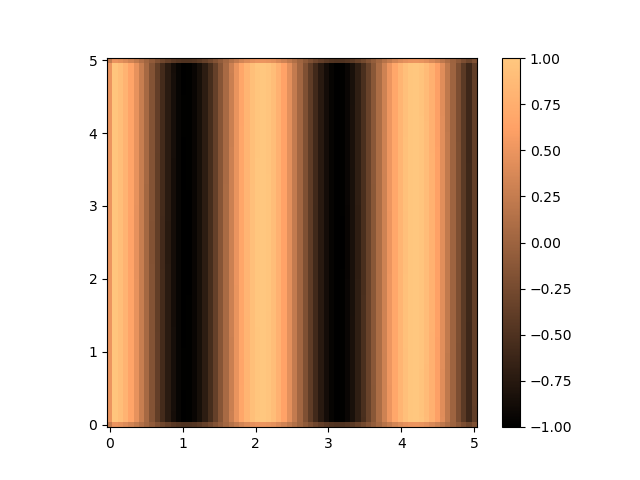

In [74]:
bem_field = (interiorPhi.reshape((Y.shape))).real

fig2, ax2 = plt.subplots()
plot = ax2.pcolormesh(X, Y, bem_field , edgecolor="none",cmap="copper")
cbar = fig2.colorbar(plot,ax=ax2)
ax2.axis('equal')
ax2.set_aspect('equal', 'box')
#plt.title(r"BEM field")
plt.show()

---

In [18]:
%%time
Gmat, Hmat = assem(coords,elems,k,"internal")

CPU times: total: 2min 20s
Wall time: 2min 21s


In [19]:
q_boundary = solve(Gmat, Hmat.dot(u_boundary))

In [20]:
%%time
sol_af = eval_sol(eval_points, coords, elems, u_boundary, q_boundary, k, "internal")

CPU times: total: 38min 38s
Wall time: 38min 47s


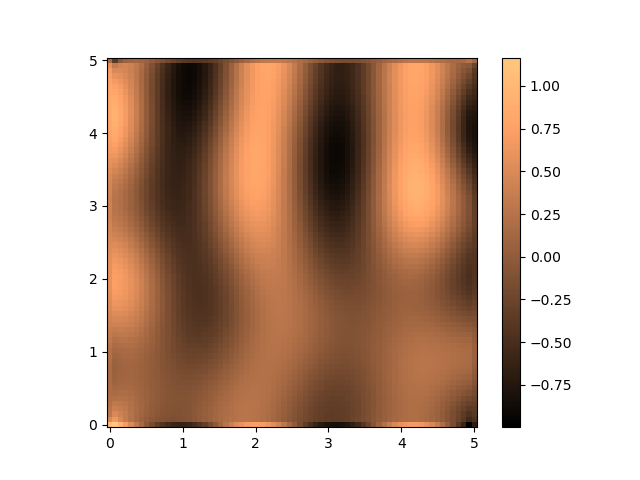

In [79]:
bem_field_af = (sol_af.reshape((Y.shape))).real

fig3, ax3 = plt.subplots()
plot = ax3.pcolormesh(X, Y, -bem_field_af , edgecolor="none",cmap="copper")

cbar = fig3.colorbar(plot,ax=ax3)
ax3.axis('equal')
ax3.set_aspect('equal', 'box')
#plt.title(r"BEM field")
plt.show()

---

### Error Estimation

In [41]:
def nrmse(A, B, norm_type='range'):
    A = np.array(A)
    B = np.array(B)
    mse = np.mean((A - B)**2)
    rmse = np.sqrt(mse)
    
    if norm_type == 'range':
        norm_factor = A.max() - A.min()
    elif norm_type == 'std':
        norm_factor = A.std()
    else:
        raise ValueError("norm_type must be 'range' or 'std'")
    
    return rmse / norm_factor if norm_factor != 0 else np.inf

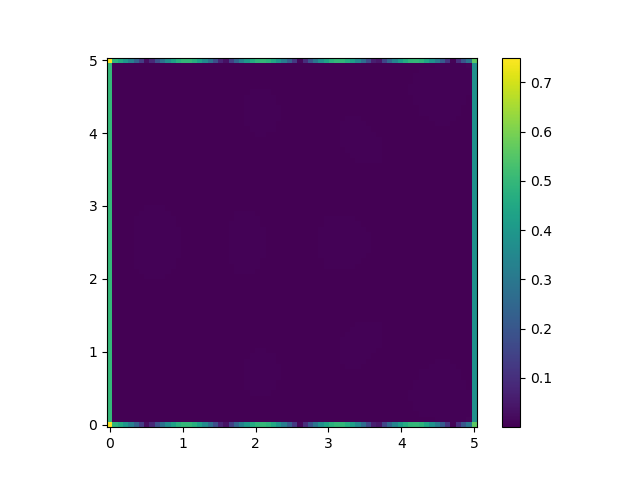

In [76]:
rerr_activeBEM = abs(bem_field-ui_fun(k,X,Y))

fig4, ax4 = plt.subplots()
plot = ax4.pcolormesh(X, Y, rerr_activeBEM , edgecolor="none",cmap="viridis")
cbar = fig4.colorbar(plot,ax=ax4)
ax4.axis('equal')
ax4.set_aspect('equal', 'box')
plt.show()

In [64]:
NRMSE_activeBEM = nrmse(ui_fun(k,X,Y) , bem_field, norm_type='range')
print("NRMSE for the activeBEM case:", NRMSE_activeBEM*100, "%")

NRMSE for the activeBEM case: 4.789660473350618 %


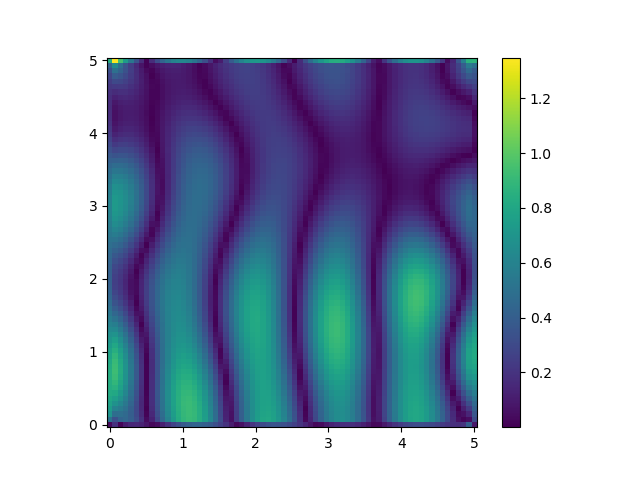

In [77]:
rerr_afBEM = abs(-bem_field_af-ui_fun(k,X,Y))

fig5, ax5 = plt.subplots()
plot = ax5.pcolormesh(X, Y, rerr_afBEM , edgecolor="none",cmap="viridis")
cbar = fig5.colorbar(plot,ax=ax5)
ax5.axis('equal')
ax5.set_aspect('equal', 'box')
plt.show()

In [67]:
NRMSE_afBEM = nrmse(ui_fun(k,X,Y) , -bem_field_af, norm_type='range')
print("NRMSE for the activeBEM case:", NRMSE_afBEM*100, "%")

NRMSE for the activeBEM case: 20.61436272105078 %
